In [1]:
import numpy as np
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from controller_Nash import PCEController
from scipy.linalg import solve_continuous_lyapunov as solve_lyapunov
from numpy.linalg import norm, inv
from scipy.integrate import solve_ivp
from scipy.special import eval_legendre

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\shun-\AppData\Local\Temp\ipykernel_17276\1187634122.py:3: SyntaxWarning: invalid escape sequence '\d'
  """


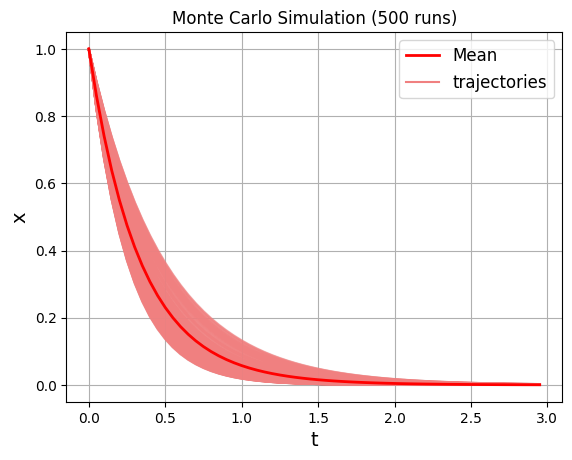

In [2]:
# モンテカルロ法で実装。非入力系
def solve_differential_equation(delta, x0, t_span, t_eval):
    """
    \dot{x} = A_delta @ x を解く関数
    """
    A_delta = np.array([
        [-3.0 + delta]
    ])
    def model(t, x):
        return A_delta @ x
    solution = solve_ivp(model, t_span, x0, t_eval=t_eval)
    return solution

# --- シミュレーションのパラメータ設定 ---
num_simulations = 500
initial_conditions = [1.0]
time_span = (0, 3)
evaluation_times = np.arange(time_span[0], time_span[1], 0.05)

# --- モンテカルロシミュレーションの実行 ---
results_list = []
for _ in range(num_simulations):
    delta_value = np.random.uniform(-1, 1)
    sol = solve_differential_equation(
        delta_value,
        initial_conditions,
        time_span,
        evaluation_times
    )
    results_list.append(sol.y)

# --- 結果の集計とプロット ---
all_results = np.array(results_list)
mean_trajectory = np.mean(all_results, axis=0)

# --- グラフの描画 ---
plt.title(f'Monte Carlo Simulation ({num_simulations} runs)')
plt.xlabel('t',fontsize=14)
plt.ylabel('x',fontsize=14)
plt.grid(True)

# 100回分の個別の軌道をプロット (半透明)
for result in all_results:
    # 赤系でプロット
    plt.plot(evaluation_times, result[0], color='lightcoral', alpha=0.2)

# 平均軌道をプロット (濃い色、太い線)
# 平均を赤でプロット
plt.plot(evaluation_times, mean_trajectory[0], color='red', linewidth=2, label='Mean')

# 凡例用のダミープロット
plt.plot([], [], color='lightcoral', label='trajectories')

plt.legend(fontsize=12)
plt.show()

In [3]:
# 多項式カオス展開により実行
# システム行列の例
def A_delta(delta):
    return np.array([
    [-3.0 + delta]
])

def B1_delta(delta):
    return np.array([
    [1.0]
])

def B2_delta(delta):
    return np.array([
    [0.1]
])

Q1 = np.array([[1]])
Q2 = np.array([[0.1]])
R11 = np.array([[1]])
R12 = np.array([[0]])
R21 = np.array([[0]])
R22 = np.array([[1]])
p_order = 4
p_terms = p_order +1
# インスタンス生成（関数の参照を渡す！）
controller = PCEController(A_delta, B1_delta, B2_delta, Q1, Q2, R11, R12, R21, R22, p_order)
# gPC行列の計算
Agpc = controller.Agpc
print("gPC行列 A:\n", np.around(Agpc, decimals=8))

gPC行列 A:
 [[-3.          0.33333333 -0.          0.         -0.        ]
 [ 1.         -3.          0.4        -0.          0.        ]
 [-0.          0.66666667 -3.          0.42857143 -0.        ]
 [ 0.         -0.          0.6        -3.          0.44444444]
 [-0.          0.         -0.          0.57142857 -3.        ]]


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\shun-\AppData\Local\Temp\ipykernel_17276\2601910800.py:2: SyntaxWarning: invalid escape sequence '\d'
  """


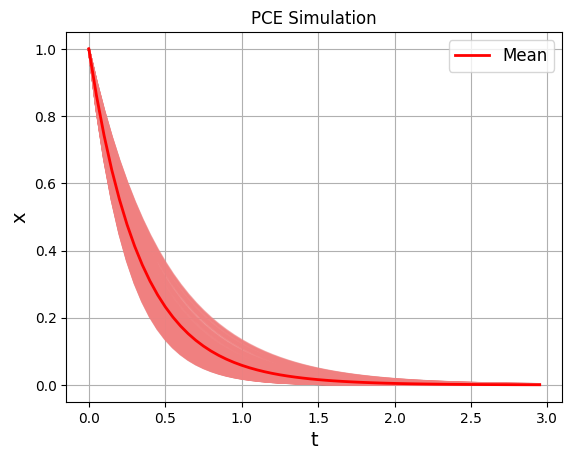

In [4]:
def solve_differential_equation(Agpc, x0, t_span, t_eval):
    """
    \dot{x} = Agpc @ x を解く関数
    """
    def model(t, x):
        return Agpc @ x
    solution = solve_ivp(model, t_span, x0, t_eval=t_eval)
    return solution

# --- パラメータと初期条件の設定 ---
# 初期値 [x1(0), x2(0)]
x0 = [0]*(p_terms)
x_o = [1]
nominal_indices = [0,p_terms]
for i, val in zip(nominal_indices, x_o):
    x0[i] = val

# 計算する時間範囲 (0秒から10秒まで)
time_span = (0, 3)

# 解を求める時間点 (0.1秒ごと)
evaluation_times = np.arange(time_span[0], time_span[1], 0.05)


# --- 微分方程式を解いて結果をプロット ---
# 関数を呼び出して解を計算
sol = solve_differential_equation(Agpc, x0, time_span, evaluation_times)

# MCであらゆるθに対してplotする
def calcurate_variance(data, index, p_terms):
    var = 0
    for i in range(1,p_terms):
        coeffs = data[(index-1)*p_terms+i]
        norm = 1/(2*i+1)
        var += norm*coeffs**2
    return var
def calcurate_legendre_polynomial(n, x):
    """Calculate the nth Legendre polynomial at point x."""
    return eval_legendre(n, x)

mean_x1 = sol.y[0]
var_x1 = calcurate_variance(sol.y, 1, p_terms) 

# t-xのグラフを描画
for i in range(500):
    theta = np.random.uniform(low=-1.0, high=1.0)
    # print(theta)
    x1 = 0
    for j in range(p_terms):
        coeffs_x1 = sol.y[(0)*p_terms+j]
        x1 += coeffs_x1 * calcurate_legendre_polynomial(j, theta)
    plt.plot(sol.t, x1, color = 'lightcoral', alpha=0.2)
# 平均軌道をプロット (濃い色、太い線)
# 平均を赤でプロット
plt.plot(sol.t, mean_x1, color='red', linewidth=2, label='Mean')
plt.title(f'PCE Simulation')
plt.xlabel('t', fontsize=14)
plt.ylabel('x', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


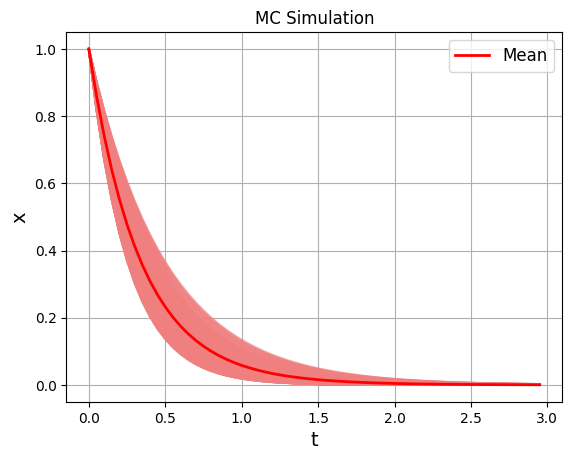

In [19]:
# t-xのグラフを描画
x0 = 1.0
time_span = (0, 3)
t = np.arange(time_span[0], time_span[1], 0.05)
x_all = []
for i in range(500):
    x_list = []
    theta = np.random.uniform(low=-1.0, high=1.0)
    for t_i in t:
        # print(theta)
        x1 = x0*np.exp((-3+theta)*t_i)
        x_list.append(x1)
    x_all.append(x_list)
    plt.plot(t, x_list, color = 'lightcoral', alpha=0.2)
mean_x1 = np.mean(x_all, axis=0)
# 平均軌道をプロット (濃い色、太い線)
# 平均を赤でプロット
plt.plot(t, mean_x1, color='red', linewidth=2, label='Mean')
plt.title(f'MC Simulation')
plt.xlabel('t', fontsize=14)
plt.ylabel('x', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()
